In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
import random

In [2]:
tf.__version__ 

'2.10.1'

In [3]:
# Load data
df = pd.read_csv('data.csv')
# Convert the cyclic frequency into sin and cos distributions
df['Freq_Log'] = np.log10(df.pop("Frequency"))-2
df["Freq_sin"] = np.sin(df['Freq_Log'] * (2 * np.pi / 8.0))
df["Freq_cos"] = np.cos(df['Freq_Log'] * (2 * np.pi / 8.0))
df[np.abs(df) < 1e-15] = 0
df.pop("Freq_Log")

0         4.0
1         3.9
2         3.8
3         3.7
4         3.6
         ... 
809995   -3.6
809996   -3.7
809997   -3.8
809998   -3.9
809999   -4.0
Name: Freq_Log, Length: 810000, dtype: float64

In [4]:
# inverse function takes the normalized y and transforms it to pysical y which represent Zre Zimg |Z| and Phase angle in each column
def inverse(scaler,ary):
    #ary is the three dimensional numpy array with first dimension being the amount of predicted, second being 20 which is the forecasing number and thrid being 4 representing each label
    x = {}
    shape = ary.shape[0]*ary.shape[1]
    y_pred_reshape = ary.reshape((shape, 4))
    y_pred_reshape_pad = np.hstack((y_pred_reshape, np.zeros((shape,2))))
    y_back = scaler.inverse_transform(y_pred_reshape_pad)[:, :4]
    y_back = y_back.reshape((ary.shape[0], ary.shape[1], 4))
    return y_back


In [5]:
# Spllit the dataset into features and labels
def create_dataset(dataset, period=81, look_back=61, future=20):
    X, Y = [], []
    for i in range(len(dataset)//period):
        start = i*period
        a = dataset[start:(start+look_back)]
        X.append(a)
        b = dataset[start+look_back:start+look_back+future,:4]
        Y.append(b)
    return np.array(X), np.array(Y)

In [6]:
#Load the scaler for normlization
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

c:\Users\Cui\AppData\Local\miniconda3\envs\tf\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
#This function calculates the R2 values between the ground truth and the predicted on Zre, Zimg, |Z| and phase angle, 
#It turns a dataframe
#The index of this dataframe is the same index on the test_df
def Cal_r2(y_test, y_pred):
    r2_dict = {'Zre':[], 'Zimg':[], "|Z|":[], 'Phase angle':[]}
    r2_df = pd.DataFrame(r2_dict)
    Zre_pred = y_pred[:, :, 0]
    Zre_test = y_test[:, :, 0]
    Zimg_pred = y_pred[:, :, 1]
    Zimg_test = y_test[:, :, 1]
    absZ_pred = y_pred[:, :, 2]
    absZ_test = y_test[:, :, 2]
    phase_pred = y_pred[:, :, 3]
    phase_test = y_test[:, :, 3]
    Zre_r2_ls = np.array([r2_score(Zre_test[i], Zre_pred[i]) for i in range(len(y_test))])
    Zimg_r2_ls = np.array([r2_score(Zimg_test[i], Zimg_pred[i]) for i in range(len(y_test))])
    absZ_r2_ls = np.array([r2_score(absZ_test[i], absZ_pred[i]) for i in range(len(y_test))])
    phase_r2_ls = np.array([r2_score(phase_test[i], phase_pred[i]) for i in range(len(y_test))])
    r2_df.Zre = Zre_r2_ls
    r2_df.Zimg = Zimg_r2_ls
    r2_df['|Z|'] = absZ_r2_ls
    r2_df['Phase angle'] = phase_r2_ls
    return r2_df


In [8]:
# Normalize the dataset
df_norm = scaler.transform(df)

In [9]:
#Split the dataset into train, validation and test
x, y = create_dataset(df_norm)
x_train = x[:8000]
y_train = y[:8000]
x_val = x[8000:9000]
y_val = y[8000:9000]
x_test = x[9000:]
y_test = y[9000:]

In [11]:
lstm_model = load_model('LSTM_model.keras')
dense_model = load_model('Dense_model.keras')
# CONV_WIDTH = 5
conv_model = load_model('CONV_model.keras')
transformer_model = load_model("Transformer_model.keras")

In [12]:
lstm_pred = lstm_model.predict(x_test)
dense_pred = dense_model.predict(x_test)
conv_pred = conv_model.predict(x_test)
transformer_pred = transformer_model.predict(x_test)

32/32 [==============================] - 1s 8ms/step


In [ ]:
dense_r2 = Cal_r2(y_test, dense_pred)
lstm_r2 = Cal_r2(y_test, lstm_pred)
conv_r2 = Cal_r2(y_test, conv_pred)
transformer_r2 = Cal_r2(y_test, transformer_pred)

269


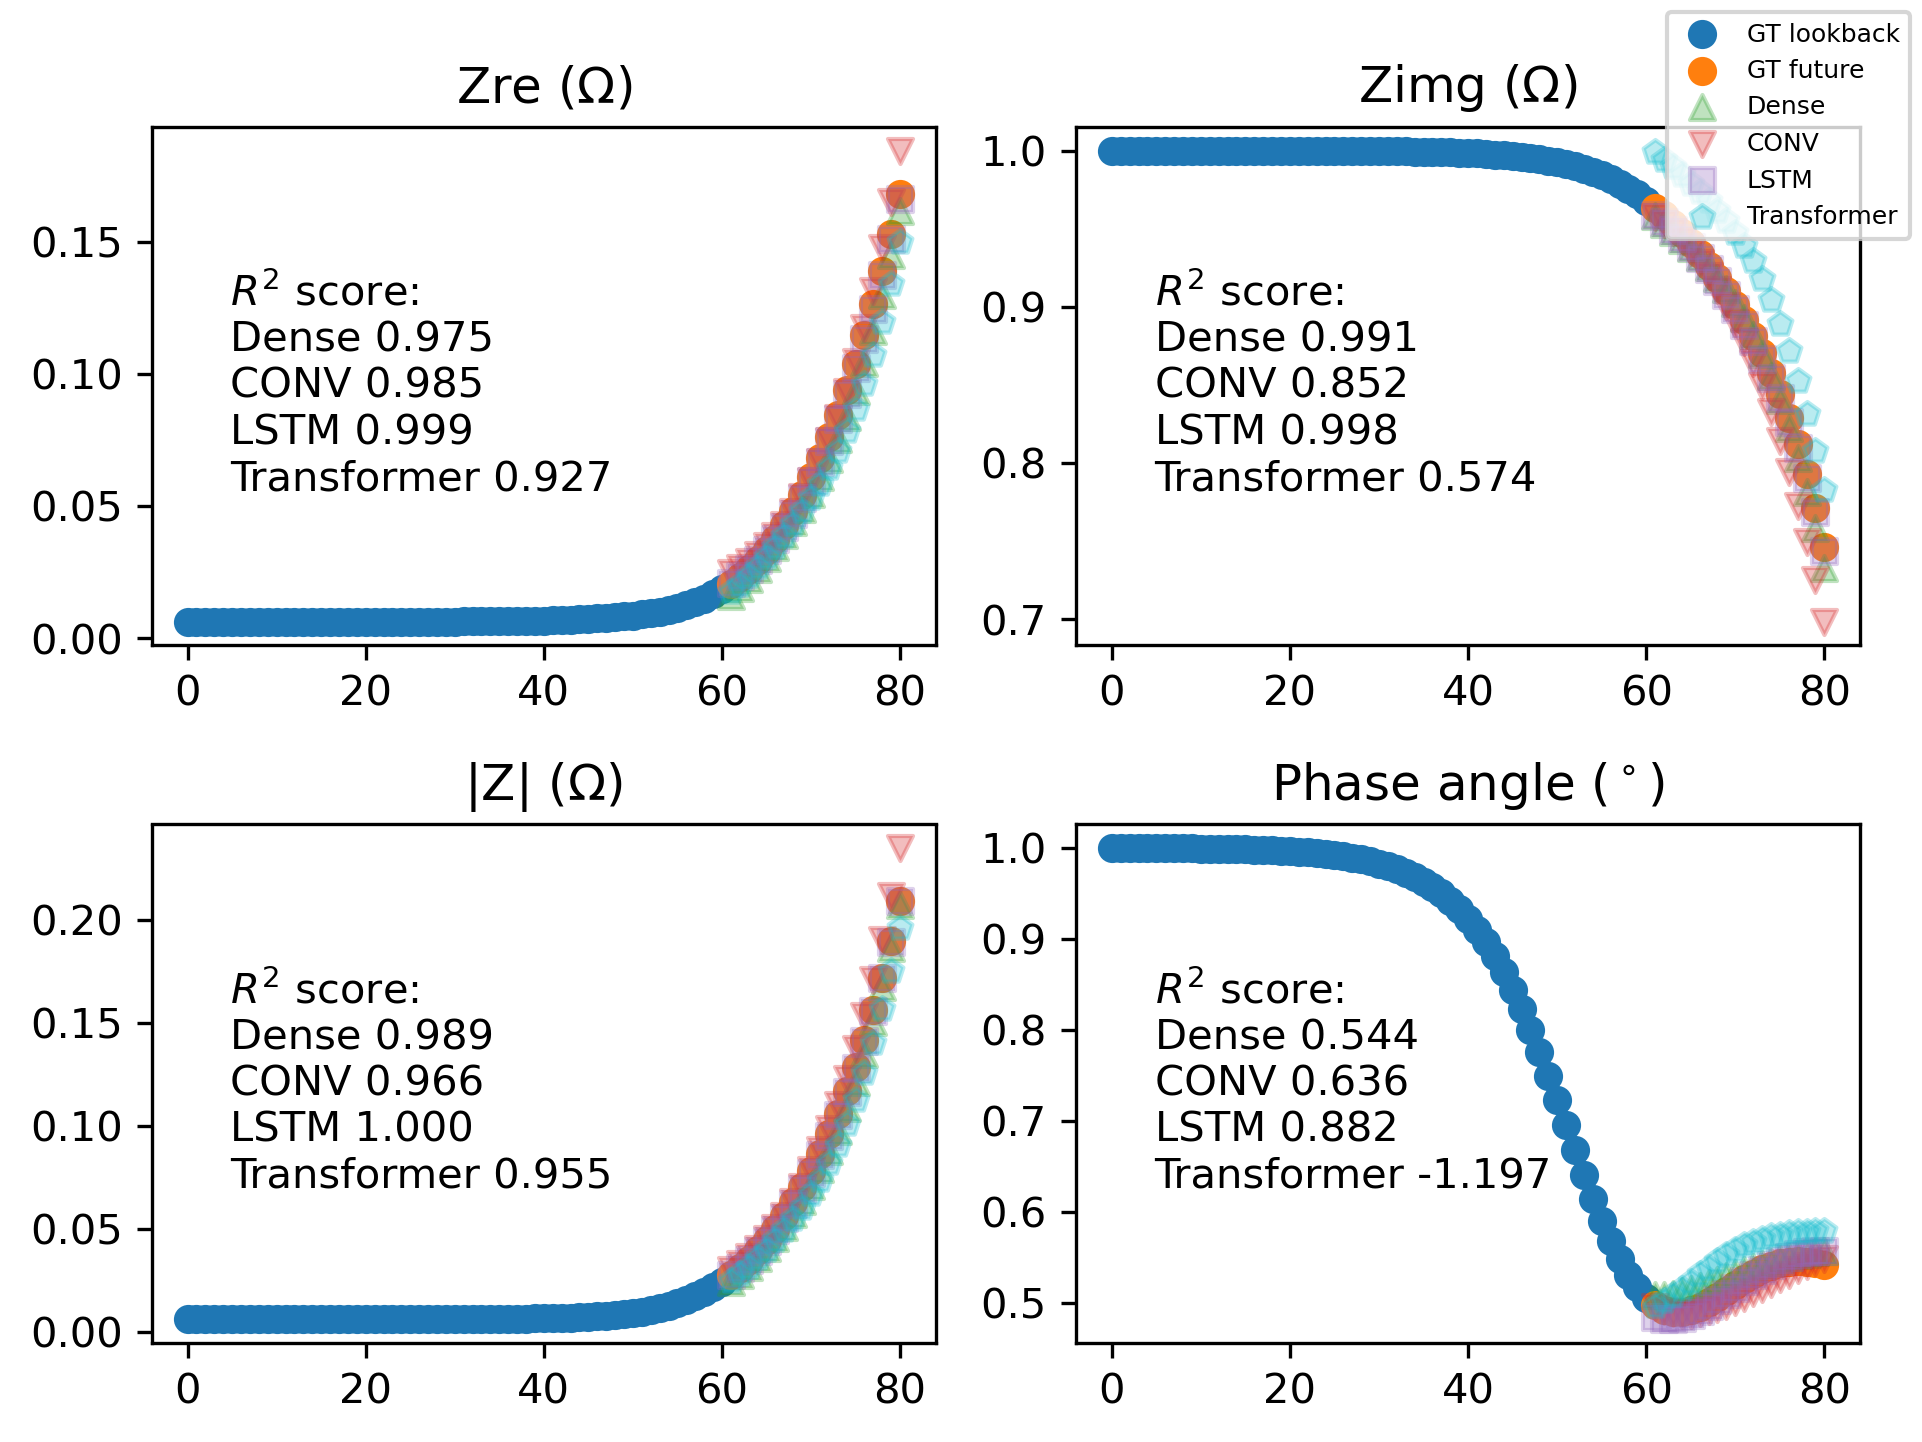

In [42]:
def plot():
    k = random.randint(0,1000)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple','tab:cyan']
    print(k)
    fig, axs = plt.subplots(2, 2)
    for i in range(4):
        ax = axs[i//2, i%2]
        ax.scatter(range(61), x_test[k, :, i], color=colors[0], marker = 'o',label = 'GT lookback')
        ax.scatter(range(61, 81), y_test[k, :, i], c=colors[1], marker='o', label = 'GT future')
        ax.scatter(range(61, 81), dense_pred[k, :, i], c=colors[2], marker='^',alpha=0.3,label = 'Dense')
        ax.scatter(range(61, 81), conv_pred[k, :, i], c=colors[3], marker='v',alpha=0.3,label = 'CONV')
        ax.scatter(range(61, 81), lstm_pred[k, :, i], c=colors[4], marker='s',alpha=0.3,label = 'LSTM')
        ax.scatter(range(61, 81), transformer_pred[k, :, i], marker='p',c=colors[5], alpha=0.3, label = 'Transformer')
        ax.text(0.1, 0.3, "$R^2$ score:\nDense {:.3f}\nCONV {:.3f}\nLSTM {:.3f}\nTransformer {:.3f}".format(r2_score(y_test[k, :, i],dense_pred[k, :, i]),
                                                                                                            r2_score(y_test[k, :, i],conv_pred[k, :, i]),
                                                                                                            r2_score(y_test[k, :, i],lstm_pred[k, :, i]),
                                                                                                            r2_score(y_test[k, :, i],transformer_pred[k, :, i])), transform=ax.transAxes)
        ax.set_title([r'Zre ($\Omega$)',r'Zimg ($\Omega$)',r'|Z| ($\Omega$)',r'Phase angle ($^\circ$)'][i])
    fig.dpi = 300
    fig.legend(["GT lookback", 'GT future', 'Dense', 'CONV', 'LSTM', "Transformer"], prop={"size":6})
    plt.tight_layout()

plot()

NameError: name 'lstm_r2' is not defined